# Create your own pricing model

Pre-requisites: Notebook 1.1, 1.2

In this notebook we will show how you can create your own monte carlo pricing model, using the base `MCModel` from the qablet library. We will implement a simple black-scholes flat volatility model where the stock price is given by
$$ 
S_t = e^{X_t}
$$ 
where $X_t$ is the lognormal stock process that evolves as
$$
dX_t = (r - \sigma^2/2) dt + dZ 
$$

$$
dZ = \sqrt{dt} \cdot \sigma \cdot dW
$$
where $r$ is the riskfree rate, $\sigma$ is the volatility, and $dW$ is a standard normal Brownian motion.

Let us start with the imports.

In [ ]:
import numpy as np
from math import sqrt
from qablet.base.mc import MCModel, MCStateBase  # The two base classes we need for our custom model
from numpy.random import Generator, SFC64
from qablet.base.utils import Forwards
from qablet_contracts.equity.vanilla import option_timetable   # We will use the utility option_timetable instead of writing our own
from matplotlib import pyplot as plt
from qablet.base.flags import Stats

## Create the Model State Class
We need to create a class that maintains the model state as the simulation moves forward in each timestep. It must inherit from `MCStateBase` and implement the following three methods.

```
class MyModelStateMC(MCStateBase):
    def __init__(self, timetable, dataset):
        <Here initialize your model parameters, and
        the vectors that keep the state variables of the model>

    def advance(self, new_time):
        <Here generate the random numbers, and 
        advance the model state variables to the new time>
 
    def get_value(self, unit):
        if this unit is handled by your model
            return value based on your model
        else:
            return None
```

Here is a working implementation of the Black-Scholes model state. In the dataset it expects a a component `BS` to contain the model parameters:
 - `ASSET` : the name of the asset that will be handled by this model
 - `VOL` : the volatility

In [ ]:
# Monte Carlo Pricer for BS (flat vol) Model

# Define a class for the state of a single asset BS MC process
class BSStateMC(MCStateBase):
    def __init__(self, timetable, dataset):

        super().__init__(timetable, dataset)

        # fetch the model parameters from the dataset
        self.n = dataset["MC"]["PATHS"]
        self.asset = dataset["BS"]["ASSET"]
        self.asset_fwd = Forwards(dataset["ASSETS"][self.asset])
        self.spot = self.asset_fwd.forward(0)
        self.vol = dataset["BS"]["VOL"]

        # Initialize the arrays
        self.rng = Generator(SFC64(dataset["MC"]["SEED"]))
        self.x_vec = np.zeros(self.n)  # process x (log stock)

        self.cur_time = 0


    def advance(self, new_time):
        """Update x_vec in place when we move simulation by time dt."""

        dt = new_time - self.cur_time
        if dt < 1e-10:
            return
        
        fwd_rate = self.asset_fwd.rate(new_time, self.cur_time)

        # generate the random numbers and advance the log stock process
        dz_vec = self.rng.standard_normal(self.n) * sqrt(dt) * self.vol

        self.x_vec += (fwd_rate - self.vol * self.vol / 2.0) * dt
        self.x_vec += dz_vec

        self.cur_time = new_time

    def get_value(self, unit):
        """Return the value of the unit at the current time.
        This model uses black scholes model for one asset, return its value using the simulated array.
        For any other asset that may exist in the timetable, just return the default implementation in
        the model base (i.e. simply return the forwards)."""

        if unit == self.asset:
            return self.spot * np.exp(self.x_vec)
        else:
            return None


## Create the Model class
We will now create the model class. In this case all we have to do is specify the state_class to be used by this model.

In [ ]:
class BSMCModel(MCModel):

    def state_class(self):
        return BSStateMC

## Create a vanilla option contract

In [ ]:
strike = 2800
timetable = option_timetable("USD", "SPX", strike=strike, maturity=1.0, is_call=True)
print(timetable["events"].to_pandas())

  track  time op  quantity unit
0         1.0  >       0.0  USD
1         1.0  +   -2800.0  USD
2         1.0  +       1.0  SPX


## Create the dataset
Create the dataset, with MC params, discounts and fwds as in previous examples. Add the two parameters needed by our model - BS_ASSET and BS_VOL.

In [ ]:

times = np.array([0.0, 1.0, 2.0, 5.0])
rates = np.array([0.04, 0.04, 0.045, 0.05]) * 0.0
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))


spot = 2900
div_rate = 0.01
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 250,
        "SEED": 1,
        "FLAGS": Stats.PV_VEC
    },
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "BS": {
        "ASSET": "SPX",
        "VOL": 0.175,
    }
}


## Calculate Price

In [ ]:
model = BSMCModel()
price, stats = model.price(timetable, dataset)
print(f"price: {price:11.6f}")

price:  234.552821


We can also analyse the behavior of the pricing model using the same tools we saw in the last notebook, e.g. get the prices for each path by specifying `PV_VEC` flag.

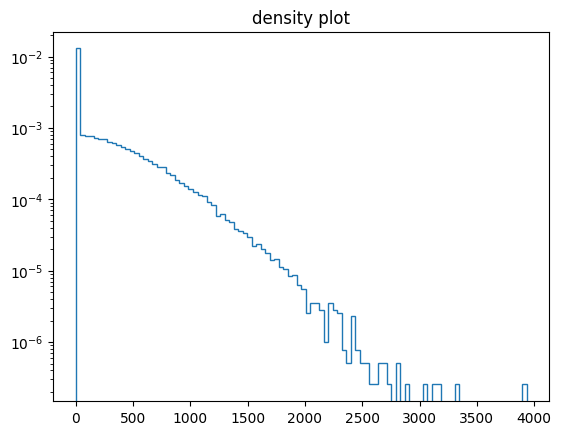

In [ ]:
   
pv_vec = stats["PV_VEC"]
plt.hist(pv_vec, bins=100, density=True, histtype="step", log=True)
plt.title("density plot") 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6357ff-4a45-421b-9726-87fe96e1ac03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>